In [1]:
import pyemu
import matplotlib.pyplot as plt
import numpy as np
import flopy as fp

In [6]:
import pypestutils
from pypestutils.pestutilslib import PestUtilsLib

In [7]:
lib = PestUtilsLib()

OSError: Could not load pestutils library

In [3]:
import xarray
ds = xarray.load_dataset('../background/mcdonald_valley_truth.nc')

# Cook up some tasty "reality"

In [4]:
nrow = 40
ncol = 25
nlay = 5

top = np.ones((nrow, ncol)) * 400
botm = np.zeros((nlay, nrow, ncol))
botm[0, :, :] = top - 50 
delr = np.full((ncol,), 500)
delc = np.full((nrow,), 500)
ibound = np.ones((nlay, nrow, ncol))

modelgrid = fp.discretization.StructuredGrid(
    delc,
    delr,
    top,
    botm,
    ibound,
)
print(modelgrid)
print(type(modelgrid))

xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0
<class 'flopy.discretization.structuredgrid.StructuredGrid'>


In [5]:
easting = modelgrid.get_xcellcenters_for_layer(0).flatten()
northing = modelgrid.get_ycellcenters_for_layer(0).flatten()

## first the shallow aquifer

In [6]:
# cell area
area = np.ones_like(easting)*500*500
#active array
active = area.copy().astype(int)
# property mean
mean = np.ones_like(easting) * 250
# property variance
var = np.ones_like(easting) * 15000
# the variogram range
aa = np.ones_like(easting)*5000
# anisotropy
anis = np.ones_like(easting)*2.1
# bearing
bearing = (np.ones_like(easting) * 150)
lib.initialize_randgen(42)
transform = "none"
variogram_type = "exp"
power = 1.0 #unused
num_reals = 1
reals = lib.fieldgen2d_sva(
    easting,
    northing,
    area,active,mean,var,aa,anis,bearing,transform,'exp',power=4,nreal=1
)
reals.shape

INFO:PestUtilsLib: initialized the random number generator
INFO:PestUtilsLib: generated 2D stochastic fields for 1 realisations


(1000, 1)

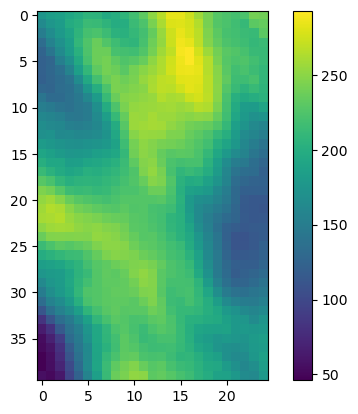

In [7]:
aqtopK = reals.reshape(nrow,ncol)
plt.imshow(aqtopK)
plt.colorbar()

In [8]:
oldK = ds.k1_layer1.data
print('Old Layer 1: ' + f'{np.nanmean(oldK)},{np.nanmin(oldK)},{np.nanmax(oldK)}')
oldK = ds.k1_layer2.data
print('Old Layer 2: ' + f'{np.nanmean(oldK)},{np.nanmin(oldK)},{np.nanmax(oldK)}')
print('New Layer 1: ' + f'{np.mean(aqtopK)},{np.min(aqtopK)},{np.max(aqtopK)}')

Old Layer 1: 219.94195721925135,41.23,449.9
Old Layer 2: 226.17287,43.96,452.52
New Layer 1: 201.81680215878404,46.01182850907861,293.0736694163147


## Now the clay

In [9]:
# cell area
area = np.ones_like(easting)*500*500
#active array
active = ds.clay_location.data.flatten()
# property mean
mean = np.ones_like(easting) * .01
# property variance
var = np.ones_like(easting) * .005
# the variogram range
aa = np.ones_like(easting)*12000
# anisotropy
anis = np.ones_like(easting)*1
# bearing
bearing = (np.ones_like(easting))
lib.initialize_randgen(420)
transform = "none"
variogram_type = "exp"
power = 1.0 #unused
num_reals = 1
reals = lib.fieldgen2d_sva(
    easting,
    northing,
    area,active,mean,var,aa,anis,bearing,transform,'exp',power=4,nreal=1
)
reals.shape

INFO:PestUtilsLib: initialized the random number generator
INFO:PestUtilsLib: generated 2D stochastic fields for 1 realisations


(1000, 1)

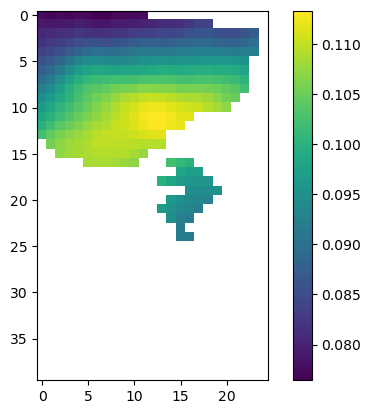

In [10]:
newck = reals.reshape(nrow,ncol)
newck[newck==0] = np.nan
plt.imshow(newck)
plt.colorbar()

In [11]:
np.nanmean(newck),np.nanmin(newck),np.nanmax(newck)

(0.09731310253682977, 0.07642661481179003, 0.11334451584939656)

In [12]:
ck = ds.clay_kv.data
ck[ck==0]=np.nan

In [13]:
np.nanmean(ck),np.nanmin(ck),np.nanmax(ck)

(0.11390494508670519, 0.091546, 0.14153049999999998)

## Then the deep aquifer

In [14]:
# cell area
area = np.ones_like(easting)*500*500
#active array
active = np.ones_like(easting).astype(int)
# property mean
mean = np.ones_like(easting) * 150
# property variance
var = np.ones_like(easting) * 1000
# the variogram range
aa = np.ones_like(easting)*3000
# anisotropy
anis = np.ones_like(easting)*2.1
# bearing
bearing = (np.ones_like(easting) * 130)
lib.initialize_randgen(24)
transform = "none"
variogram_type = "exp"
power = 1.0 #unused
num_reals = 1
reals = lib.fieldgen2d_sva(
    easting,
    northing,
    area,active,mean,var,aa,anis,bearing,transform,'exp',power=4,nreal=1
)
reals.shape

INFO:PestUtilsLib: initialized the random number generator
INFO:PestUtilsLib: generated 2D stochastic fields for 1 realisations


(1000, 1)

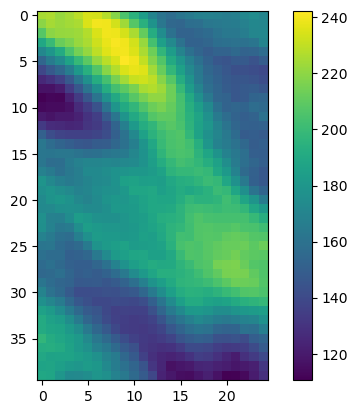

In [15]:
aqdeepK = reals.reshape(nrow,ncol)
plt.imshow(aqdeepK)
plt.colorbar()

In [16]:
oldK = ds.k1_layer4.data
print('Old Layer 4: ' + f'{np.nanmean(oldK)},{np.nanmin(oldK)},{np.nanmax(oldK)}')
oldK = ds.k1_layer5.data
print('Old Layer 5: ' + f'{np.nanmean(oldK)},{np.nanmin(oldK)},{np.nanmax(oldK)}')
print('New Layer 1: ' + f'{np.mean(aqdeepK)},{np.min(aqdeepK)},{np.max(aqdeepK)}')

Old Layer 4: 219.24304,36.26,448.53
Old Layer 5: 223.58897,41.41,445.4
New Layer 1: 174.3783190498281,110.5836887869151,242.3234360551591


In [17]:
ds

<xarray.Dataset>
Dimensions:        (y: 40, x: 25)
Coordinates:
  * x              (x) float64 250.0 750.0 1.25e+03 ... 1.175e+04 1.225e+04
  * y              (y) float64 1.975e+04 1.925e+04 1.875e+04 ... 750.0 250.0
Data variables: (12/31)
    bottom_layer1  (y, x) float64 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    bottom_layer2  (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0
    bottom_layer3  (y, x) float64 -50.63 -50.63 -50.65 ... -50.64 -50.7 -50.72
    bottom_layer4  (y, x) float64 -177.9 -173.6 -170.6 ... -110.0 -110.8 -100.8
    bottom_layer5  (y, x) float64 -303.9 -295.1 -289.2 ... -169.4 -170.9 -150.9
    head_layer1    (y, x) float64 11.33 11.32 11.3 11.28 ... 6.09 6.19 6.26 6.3
    ...             ...
    clay_kv        (y, x) float64 0.1048 0.1023 0.09946 0.1091 ... nan nan nan
    znode_layer1   (y, x) float64 3.165 3.16 3.15 3.14 ... 0.545 0.595 0.63 0.65
    znode_layer2   (y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    znode_layer3   (y, x) float64 -32.81 -32.81 -32.83 ... -32.82 -32.85 -32.86
    znode_layer4   (y, x) float64 -115.0 -112.8 -111.4 ... -80.32 -80.75 -75.78
    znode_layer5   (y, x) float64 -240.9 -234.3 -229.9 ... -139.7 -140.8 -125.9

In [18]:
ds['clay_kv'].data.shape

(40, 25)

In [19]:
ds['clay_kv'].data = newck

In [20]:
for i in [1,2]:
    ds[f'k1_layer{i}'].data = aqtopK
ds['k1_layer3'].data = newck
for i in [4,5]:
    ds[f'k1_layer{i}'].data = aqdeepK

In [21]:
ds

<xarray.Dataset>
Dimensions:        (y: 40, x: 25)
Coordinates:
  * x              (x) float64 250.0 750.0 1.25e+03 ... 1.175e+04 1.225e+04
  * y              (y) float64 1.975e+04 1.925e+04 1.875e+04 ... 750.0 250.0
Data variables: (12/31)
    bottom_layer1  (y, x) float64 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    bottom_layer2  (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0
    bottom_layer3  (y, x) float64 -50.63 -50.63 -50.65 ... -50.64 -50.7 -50.72
    bottom_layer4  (y, x) float64 -177.9 -173.6 -170.6 ... -110.0 -110.8 -100.8
    bottom_layer5  (y, x) float64 -303.9 -295.1 -289.2 ... -169.4 -170.9 -150.9
    head_layer1    (y, x) float64 11.33 11.32 11.3 11.28 ... 6.09 6.19 6.26 6.3
    ...             ...
    clay_kv        (y, x) float64 0.07766 0.07701 0.07741 ... nan nan nan
    znode_layer1   (y, x) float64 3.165 3.16 3.15 3.14 ... 0.545 0.595 0.63 0.65
    znode_layer2   (y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    znode_layer3   (y, x) float64 -32.81 -32.81 -32.83 ... -32.82 -32.85 -32.86
    znode_layer4   (y, x) float64 -115.0 -112.8 -111.4 ... -80.32 -80.75 -75.78
    znode_layer5   (y, x) float64 -240.9 -234.3 -229.9 ... -139.7 -140.8 -125.9

In [22]:
ds.to_netcdf('../background/newMVTruth.nc')

In [23]:
ds

<xarray.Dataset>
Dimensions:        (y: 40, x: 25)
Coordinates:
  * x              (x) float64 250.0 750.0 1.25e+03 ... 1.175e+04 1.225e+04
  * y              (y) float64 1.975e+04 1.925e+04 1.875e+04 ... 750.0 250.0
Data variables: (12/31)
    bottom_layer1  (y, x) float64 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    bottom_layer2  (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0
    bottom_layer3  (y, x) float64 -50.63 -50.63 -50.65 ... -50.64 -50.7 -50.72
    bottom_layer4  (y, x) float64 -177.9 -173.6 -170.6 ... -110.0 -110.8 -100.8
    bottom_layer5  (y, x) float64 -303.9 -295.1 -289.2 ... -169.4 -170.9 -150.9
    head_layer1    (y, x) float64 11.33 11.32 11.3 11.28 ... 6.09 6.19 6.26 6.3
    ...             ...
    clay_kv        (y, x) float64 0.07766 0.07701 0.07741 ... nan nan nan
    znode_layer1   (y, x) float64 3.165 3.16 3.15 3.14 ... 0.545 0.595 0.63 0.65
    znode_layer2   (y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    znode_layer3   (y, x) float64 -32.81 -32.81 -32.83 ... -32.82 -32.85 -32.86
    znode_layer4   (y, x) float64 -115.0 -112.8 -111.4 ... -80.32 -80.75 -75.78
    znode_layer5   (y, x) float64 -240.9 -234.3 -229.9 ... -139.7 -140.8 -125.9

In [24]:
ds2 = xarray.load_dataset('../background/newMVTruth.nc')

In [25]:
ds2


<xarray.Dataset>
Dimensions:        (y: 40, x: 25)
Coordinates:
  * x              (x) float64 250.0 750.0 1.25e+03 ... 1.175e+04 1.225e+04
  * y              (y) float64 1.975e+04 1.925e+04 1.875e+04 ... 750.0 250.0
Data variables: (12/31)
    bottom_layer1  (y, x) float64 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    bottom_layer2  (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0
    bottom_layer3  (y, x) float64 -50.63 -50.63 -50.65 ... -50.64 -50.7 -50.72
    bottom_layer4  (y, x) float64 -177.9 -173.6 -170.6 ... -110.0 -110.8 -100.8
    bottom_layer5  (y, x) float64 -303.9 -295.1 -289.2 ... -169.4 -170.9 -150.9
    head_layer1    (y, x) float64 11.33 11.32 11.3 11.28 ... 6.09 6.19 6.26 6.3
    ...             ...
    clay_kv        (y, x) float64 0.07766 0.07701 0.07741 ... nan nan nan
    znode_layer1   (y, x) float64 3.165 3.16 3.15 3.14 ... 0.545 0.595 0.63 0.65
    znode_layer2   (y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    znode_layer3   (y, x) float64 -32.81 -32.81 -32.83 ... -32.82 -32.85 -32.86
    znode_layer4   (y, x) float64 -115.0 -112.8 -111.4 ... -80.32 -80.75 -75.78
    znode_layer5   (y, x) float64 -240.9 -234.3 -229.9 ... -139.7 -140.8 -125.9